# IMPORT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

# FUNCTION DEFINITIONS

In [2]:
def to_rad(x):
    return x*np.pi/180

def multiwrite(outfile, string):
    outfile.write(string + "\n")
    print(string)
    
def fit_function(theta, A, m, s, r, a, b):
    # A: normalization, m: average, 2s: FWHM of Lorentzian, r: relative ratio, a b linear parameters, xi initial point of the fit, xf final point of the fit
    sg = s/np.sqrt(2*np.log(2)) # sigma of gaussian
    lor = A/np.pi*s/((theta-m)**2+s**2)
    gaus = A/(sg*np.sqrt(2*np.pi))*np.exp(-(theta-m)**2/(2*sg**2))
    line = a*l+b
    return r*lor + (1-r)*gaus + line

def d(theta):
    return l/(2*np.sin(theta))

def lattice_constant(d, h, k, l):
    return  d*np.sqrt(h**2+k**2+l**2)

def Scherrer(theta, beta):
    return K*l/(beta*np.cos(theta))

def Chi(observed, expected):
    return ((observed-expected)**2/expected).sum()

# DATA

In [3]:
fs = 20 # standardize the fontsize
l = 0.15406 # [nm], from CuKa1
beta_instr = to_rad(0.27)
K = 0.89 # using FWHM

data = pd.read_csv("Group01_GIXRD1.txt", sep=" ", header=None)
data.columns = ["2theta", "intensity"]
two_theta_deg = np.array(data["2theta"]) # [deg], detector's angle
theta = np.array(data["2theta"])*np.pi/360 # [rad], Bragg's angle
intensity = np.array(data["intensity"]) #counts

# INTENSITY SPECTRUM PLOT

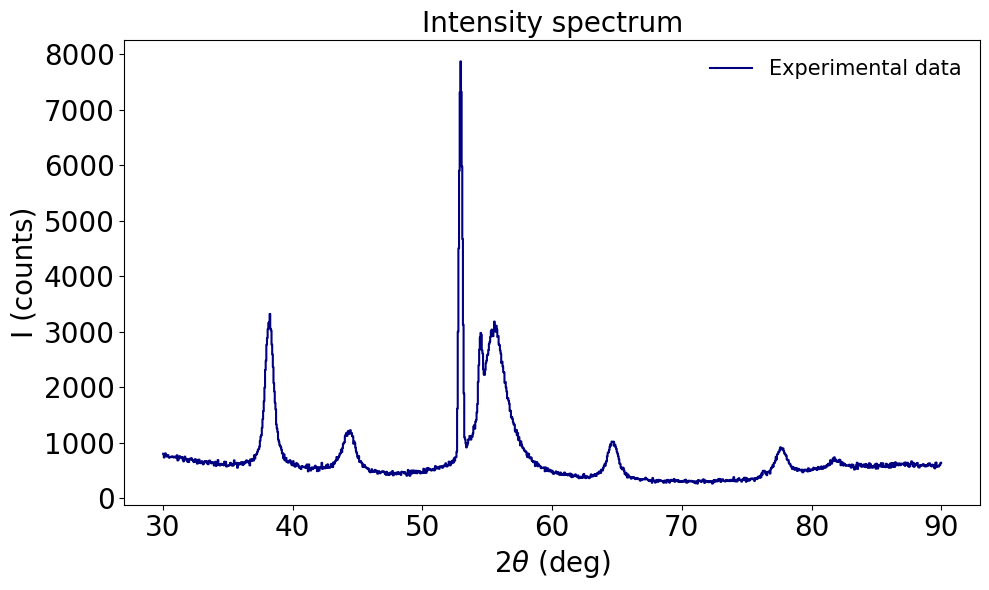

In [4]:
plt.figure(figsize=(10, 6), dpi=100)
plt.step(two_theta_deg, intensity, color="navy", label="Experimental data")
plt.title("Intensity spectrum", fontdict={"fontsize": fs})
plt.xlabel(r"$2\theta$ (deg)", fontdict={"fontsize": fs})
plt.xticks(fontsize=fs)
plt.ylabel("I (counts)", fontdict={"fontsize": fs})
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs//4*3, frameon=False)
plt.tight_layout()

# FITTING

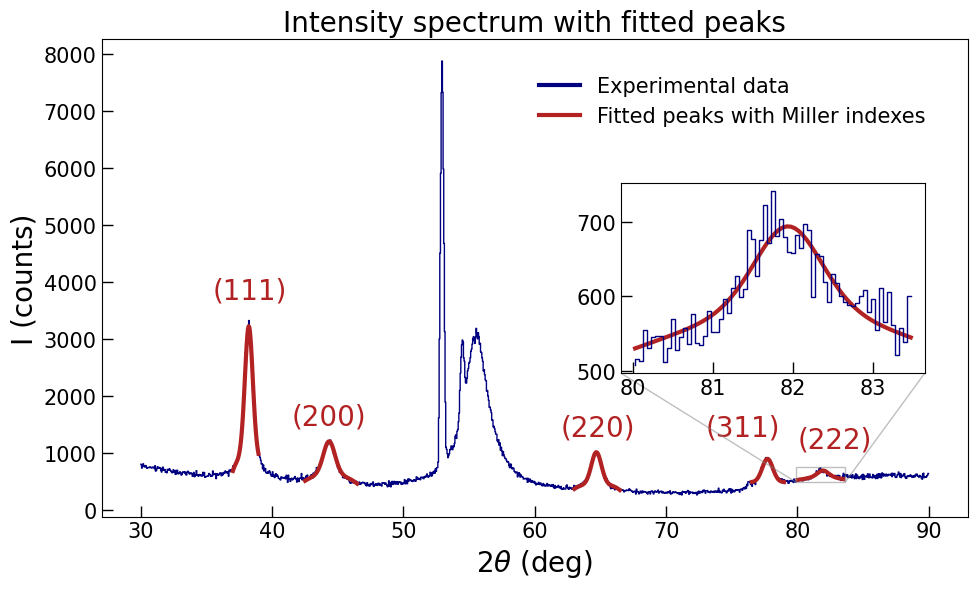

In [26]:
# creating couples of data with ranges of interest for the fits
two_theta_deg_peak1 = []
intensity_peak1 = []
two_theta_deg_peak2 = []
intensity_peak2 = []
two_theta_deg_peak3 = []
intensity_peak3 = []
two_theta_deg_peak4 = []
intensity_peak4 = []
two_theta_deg_peak5 = []
intensity_peak5 = []

for i in range(len(two_theta_deg)):
    if (two_theta_deg[i] >= 37 and two_theta_deg[i] <= 39):
        two_theta_deg_peak1.append(two_theta_deg[i])
        intensity_peak1.append(intensity[i])
    if (two_theta_deg[i] >= 42.5 and two_theta_deg[i] <= 46.5):
        two_theta_deg_peak2.append(two_theta_deg[i])
        intensity_peak2.append(intensity[i])
    if (two_theta_deg[i] >= 63 and two_theta_deg[i] <= 66.5):
        two_theta_deg_peak3.append(two_theta_deg[i])
        intensity_peak3.append(intensity[i])
    if (two_theta_deg[i] >= 76.5 and two_theta_deg[i] <= 79):
        two_theta_deg_peak4.append(two_theta_deg[i])
        intensity_peak4.append(intensity[i])
    if (two_theta_deg[i] >= 80 and two_theta_deg[i] <= 83.5):
        two_theta_deg_peak5.append(two_theta_deg[i])
        intensity_peak5.append(intensity[i])

# radiants conversion to use for fitting
theta_peak1 = np.array(two_theta_deg_peak1)*np.pi/360
theta_peak2 = np.array(two_theta_deg_peak2)*np.pi/360
theta_peak3 = np.array(two_theta_deg_peak3)*np.pi/360
theta_peak4 = np.array(two_theta_deg_peak4)*np.pi/360
theta_peak5 = np.array(two_theta_deg_peak5)*np.pi/360

# datas for fitting each of the 5 peaks
theta_peaks = [theta_peak1, theta_peak2, theta_peak3, theta_peak4, theta_peak5] # x data [rad]
intensity_peaks = [intensity_peak1,  intensity_peak2,  intensity_peak3,  intensity_peak4,  intensity_peak5] # y data

# initial guess for each parameter for fitting each of the 5 peaks
A_guess = [3000, 1200, 1000, 900, 800]
m_guess = np.array([19, 44, 65, 77, 82]) * np.pi / 360 # [rad]
s_guess = [0.5, 0.5, 0.5, 0.5, 0.5] # [rad]
r_guess = [0.5, 0.5, 0.5, 0.5, 0.5]
a_guess = [0, 0, 0, 0, 0]
b_guess = [700, 800, 600, -1000, 600]

# create canvas
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# plot all the data
ax.step(two_theta_deg, intensity, lw=1, color='navy')

FWHM = []
FWHM_err = []
# unpack each array: every cycle is a fit on a peak
for x_fit, y_fit, A, m, s, r, a, b in zip(theta_peaks, intensity_peaks, A_guess, m_guess, s_guess, r_guess, a_guess, b_guess):
    # perform the fit
    par_fit, par_cov = curve_fit(fit_function, x_fit, y_fit, p0=(A, m, s, r, a, b), maxfev=5000)
    # plot each fit
    ax.plot(x_fit*360/np.pi, fit_function(x_fit, *par_fit), lw=3, color='firebrick') # pay attention, this is in [deg] just to have the plot
    # output of s and error (FWHM of Lorentzian)
    FWHM.append(2*par_fit[2])
    FWHM_err.append(2*np.sqrt(par_cov[2,2]))

# labels
ax.set_title("Intensity spectrum with fitted peaks", fontdict={"fontsize": fs})
ax.set_xlabel(r"$2\theta$ (deg)", fontdict={"fontsize": fs})
ax.set_ylabel("I (counts)", fontdict={"fontsize": fs})

# writing legend by hand for fitted peaks (to avoid multiple outputs)
legend_elements = [Line2D([0], [0], color='navy', lw=3, label='Experimental data'),
                   Line2D([0], [0], color='firebrick', lw=3, label='Fitted peaks with Miller indexes')]
ax.legend(handles=legend_elements, loc=(0.495, 0.8), frameon=False, fontsize=fs//4*3)

# handling ticks
ax.tick_params(which='both', width=1.0, length=8, direction='in', labelsize=fs//4*3)

# zoom
inax = ax.inset_axes([0.6, 0.3, 0.35, 0.4])
inax.plot(theta_peak5*360/np.pi, fit_function(x_fit, *par_fit), lw=3, color='firebrick')
inax.step(theta_peak5*360/np.pi, intensity_peak5, lw=1, color='navy')
ax.indicate_inset_zoom(inax)

# handling ticks
inax.tick_params(which='both', width=1.0, length=8, direction='in', labelsize=fs//4*3)

# assign miller indexes
ax.text(35.5, 3700, '(111)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(41.5, 1500, '(200)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(62, 1300, '(220)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(73, 1300, '(311)', fontdict=None, fontsize = fs, color ="firebrick")
ax.text(80, 1100, '(222)', fontdict=None, fontsize = fs, color ="firebrick")

# manage layout and save
fig.tight_layout()

In [16]:
# check: changing ranges this results vary. In particular the last peak could be problematic but with (80 : 83.5) it works
print(FWHM)
print(FWHM_err)

[0.011863568119669926, 0.01725617737363697, 0.01509101631861768, 3.428313470858805e-05, 0.015205632514153035]
[0.00031026504072723647, 0.0008877372340380183, 0.0005526756376575891, 6.191234910426057, 0.005817730166441521]


# PARTICLE SIZE

In [145]:
# TODO:
# get chi quared and useful results for each peak to go on with analysis
# Calculate for each peak the corresponding value of the lattice constant a.
# Using the Scherrer equation, calculate the nanoparticle size.
